# Construction of Route Graphs

**************************************
This notebook walks you through the code in the [route_graph.py](https://gitlab.crowdai.org/SBB/train-schedule-optimisation-challenge-starter-kit/blob/master/utils/route_graph.py) script. It contains code to build directed graphs in the [networkx](https://networkx.github.io/) package from the `routes` in the problem instances. 

This should help you to better understand the `routes` and how to work with them. It may also prove useful in your solving algorithm, such as for finding zero-penalty paths or the like. If you don't like to work with the networkx package, you can copy the logic from the functions `from_node_id` and `to_node_id`, which assign the node id's, to the graph library of your choice.

To run the following code, please ensure that you use Pyhton >= 3.6 and first install the following Python libraries:
- networkx
- matplotlib
**************************************

Import libraries

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt

This function returns "from"-node id for a given `route_section`. The crucial point is that nodes with common `route_alternative_marker`s are identified as the same node in the graph.

In [2]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"

This function returns "to"-node id for a given `route_section`

In [3]:
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

## Example
We build the route graphs for the two routes in the Challenge sample_instance.

For large graphs, you probably want to deactivate the printint output.


In [4]:
scenario = "../sample_files/sample_scenario.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)
    
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))

            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       sequence_number=sn)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 111
Adding Edge from (1_beginning) to (M1) with sequence number 1
Adding Edge from (M1) to (4->5) with sequence number 4
Adding Edge from (4->5) to (M2) with sequence number 5
Adding Edge from (M2) to (M3) with sequence number 6
Adding Edge from (M3) to (10->13) with sequence number 10
Adding Edge from (10->13) to (M4) with sequence number 13
Adding Edge from (M4) to (14_end) with sequence number 14
Adding Edge from (2_beginning) to (M1) with sequence number 2
Adding Edge from (3_beginning) to (M1) with sequence number 3
Adding Edge from (M2) to (7->8) with sequence number 7
Adding Edge from (7->8) to (8->9) with sequence number 8
Adding Edge from (8->9) to (9_end) with sequence number 9
Adding Edge from (M3) to (11->12) with sequence number 11
Adding Edge from (11->12) to (M4) with sequence number 12

Constructing route graph for route 113
Adding Edge from (1_beginning) to (M1) with sequence number 1
Adding Edge from (M1) to (4->5) with sequence num

You can try to visualize the graph. Plotting directly from networkx is unfortunately not be as easy to unterstand. This is the reason for outputing graphml files which will allow you to visualize the graph in a tool of your choice.

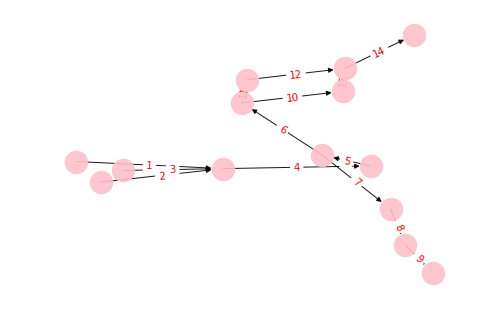

In [5]:
route_graph = route_graphs[111]

for node in route_graph.nodes():
    route_graph.node[node]['label'] = node

edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['sequence_number'] 

for edge in route_graph.edges():
    route_graph.edges[edge]['label'] = edge_labels[edge]

# export as graphML file, see below
nx.write_graphml(route_graph, "graph-111"+".graphml")

# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

However, you can also export it as graphML and use a visualization tool to render it. For example, this what it looks like after processing the graphml with [yED](https://www.yworks.com/products/yed/download). Labels on the edges represent the sequence_number. 

_Note_ On Gitlab, the Notebook not render the image properly. If you can't see anything below, please have a look at [route_graph.md](route_graph.md)

![](https://gitlab.crowdai.org/SBB/train-schedule-optimisation-challenge-starter-kit/raw/master/utils/img/graph-111.png)